# Assingment 1 - MRI Contrast Classifier
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis


Welcome to the first course assignments! We have collected a dataset based on the popular BraTS challenge (http://braintumorsegmentation.org/), containing MRI slices of the brain, of different contrasts (sometimes referred to as modalities): T1-weighted (T1w), T1-weighted with contrast agent (T1w-CE), T2-weighted (T2w), and FLAIR, also a manually segmented binary map of a tumor, if visible on the slice. 

The assignments will build on each other, and all three of them will use the same dataset and the same data generator so take your time to familiarize yourself with these.

In the first assignments you are tasked with training a convolutional neural network to classify the acquired MR data into their contrasts (T1w, T1w-CE, T2w, FLAIR).

The code below is a working, but poor implementation of classifying between T1w and T2w contrasts. Your exercise is to expand and improve the code so the final model handles all four contrasts, and achieves an accuracy of $95\%$. 

The most important aspect of the assignment is that all your choices in the final code are explained and supported in writing. Show your though process, even if you have managed to improve the accuracy by trial and error. Make sure that in the report you include:
- How you reached the required performances
- Plot the confusion matrix of the validation data, using the final model.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the current setup, and how to solve them.

Upload the updated notebook to Canvas before February $16^{th}$, 15:00.

Good luck and have fun!

## Environment setup
Following the instructions found on https://www.tensorflow.org/install/pip to setup the enviroment for tensorflow.
The Tensorflow verion used was 2.11.0 with CUDA 11.2.2 and cuDNN 8.1.0 on python 3.9.13.
After the installation of the enviroment, the following packages were installed:
- ipykernel 6.15.2
- scikit-learn 1.0.2
- scikit-image 0.19.2
- matplotlib 3.5.2

This installation is comparable to the one used in the course, but with a newer version of each individual package.
Although the my enviroment is not identical to the one used in the course, the results should be comparable and the code should run on any of the two enviroments.
There might be some differences in keywords but I've supplied a commented out version of the code that should work with the course enviroment. 

In [2]:
import os
import numpy as np
np.random.seed(2023)  # Set seed for reproducibility
import tensorflow as tf
tf.random.set_seed(2026)
!pip install tqdm # Adding tqdm to use progress bars. Unbarable waiting for each epoch to finish without feedback.
from tqdm import tqdm

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


2023-03-14 11:45:21.703207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-14 11:45:21.733282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 11:45:21.733614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.695GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-03-14 11:45:21.733755: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-14 11:45:21.734852: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-14 11:45:21.735938: I tensorflow/stream_executor/

##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!

In [5]:
# gen_dir = "/import/software/3ra023/vt23/brats/data/"  # Change if you have copied the data locally on your machine
gen_dir = "../data/"  # Change if you have copied the data locally on your machine
array_labels = ['t1', 't1ce', 't2', 'flair']  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
N_CLASSES = len(array_labels)
batch_size = 32

gen_train = DataGenerator(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? Their order will be the same as their unpacking order during training!
# NOTE: What batch size are you using? Should you use more? Or less?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

### Let's plot some example images from the dataset:

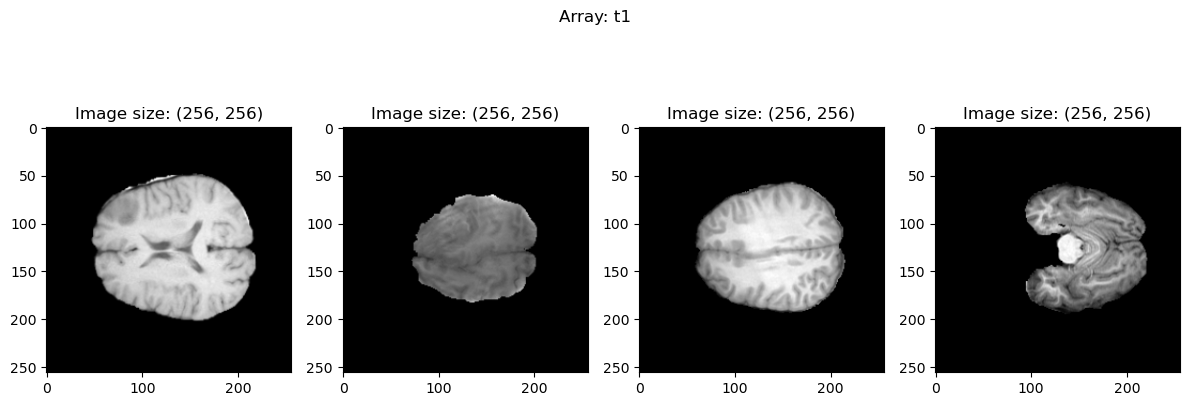

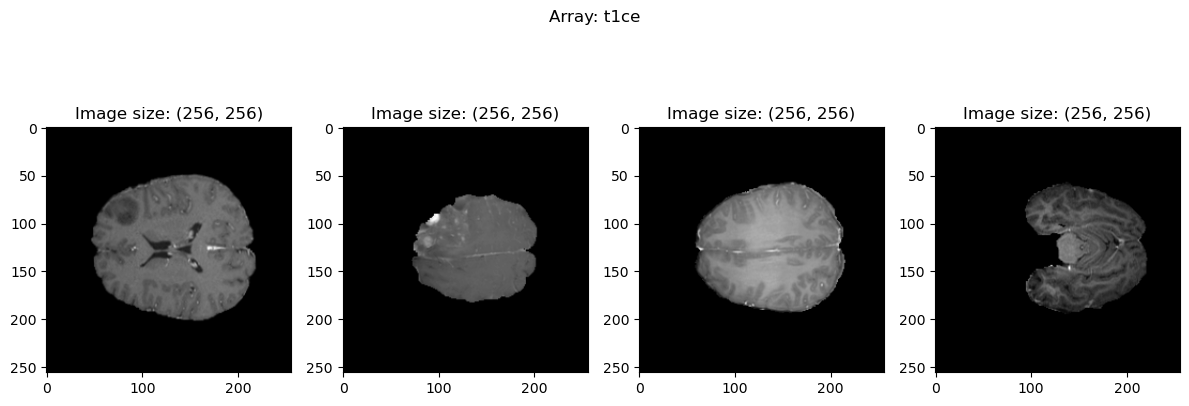

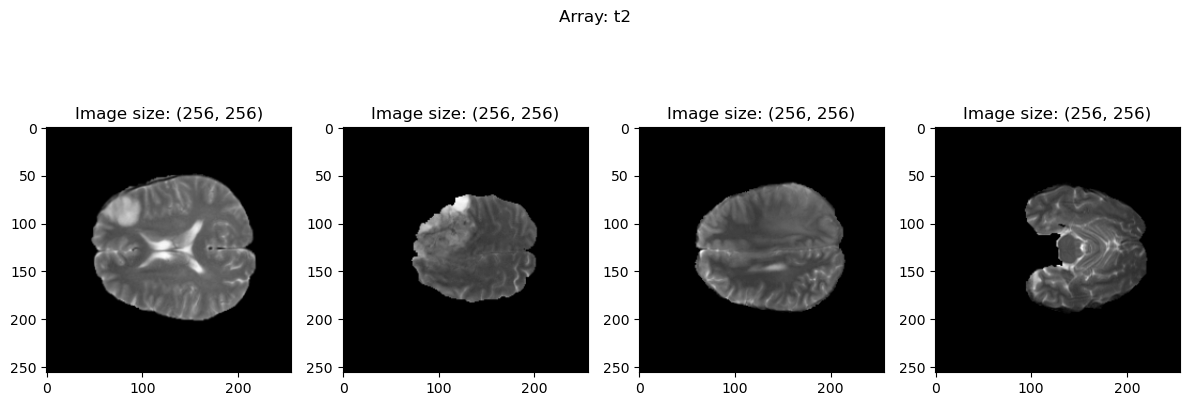

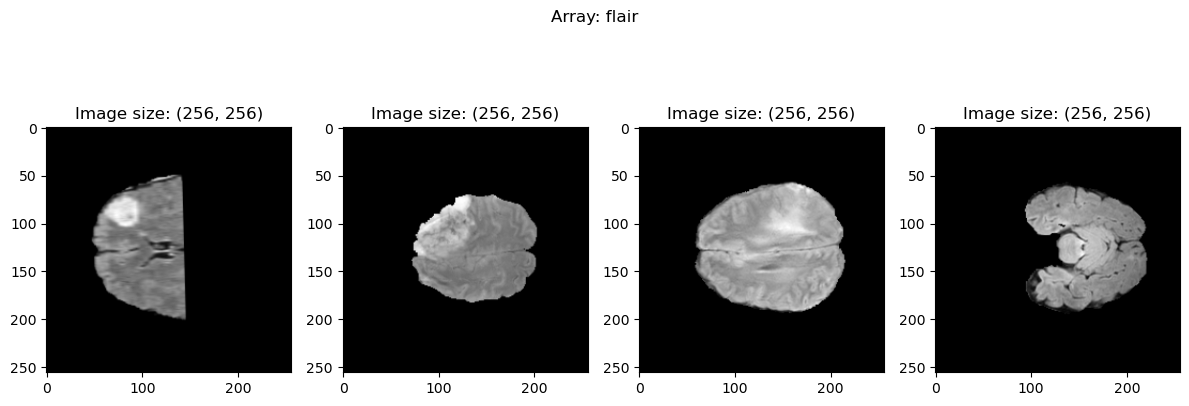

In [6]:
imgs = gen_train[0]
for inp in range(np.shape(imgs)[0]):
    plt.figure(figsize=(12,5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(imgs[inp][i, :, :, 0], cmap='gray')
        plt.title('Image size: ' + str(np.shape(imgs[inp][i, :, :, 0])))
        plt.tight_layout()
    plt.suptitle('Array: ' + gen_train.arrays[inp])
    plt.show()

### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

A quick summery of the data sizes:

In [7]:
# A quick summary of the data:
print(f"Number of training images: {str(len(gen_train.file_list))}")
print(f"Training batch size      : {str(gen_train.in_dims)}")

Number of training images: 8000
Training batch size      : [(32, 256, 256, 1), (32, 256, 256, 1), (32, 256, 256, 1), (32, 256, 256, 1)]


In [8]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

# NOTE: Take inspiration from the imported layers and components, however you are not required to use all of them.

In [9]:
def build_model(height, width, channels):
    inp = Input(shape=(height, width, channels), name='input_1')
    drop_rate = 0.1 # 0.1 Small dropout throught the network.
    conv1 = Conv2D(8, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(inp)
    #conv1 = BatchNormalization()(conv1) # During the first Training runs I had BN but worked without. 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(drop_rate)(pool1)

    conv2 = Conv2D(8, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(pool1)
    #conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(16, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(drop_rate)(pool3)
    
    conv4 = Conv2D(32, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(drop_rate)(pool4)
    
    conv5 = Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(pool4)
    #conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    pool5 = Dropout(drop_rate)(pool5)

    conv6 = Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool5)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    # Output layer to produce probabilities.
    flat = Flatten()(pool6)
    x = Dense(64, activation='relu')(flat)
    output_1 = Dense(4, activation='softmax')(x)

    return Model(inputs=[inp], outputs=[output_1])

# NOTE: A better designed network will improve performance. Look at the imported layers in the cell above for inspiration.

In [10]:
height, width, channels = gen_train.in_dims[0][1:]
model = build_model(height=height, width=width, channels=channels)
#model = build_resnet(height=height, width=width, channels=channels)

#model = build_improved_model()
model.summary()

# NOTE: Are the input sizes correct?
# NOTE: Are the output sizes correct?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are the model parameters split "evenly" between the layers? Or is there one huge layer?
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

2023-03-14 11:40:54.040901: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2023-03-14 11:40:54.072463: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 4099895000 Hz
2023-03-14 11:40:54.073076: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1969490 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-14 11:40:54.073089: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-03-14 11:40:54.124251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 11:40:54.124550: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x12e1150 initialized for platform CUDA (this does not guarantee 

In [10]:
def load_model(path):
    m = keras.models.load_model(path)
    print(m.summary())
    return m

In [11]:
custom_lr = 0.001 #0.00005, Original. NOTE: I used 0.0005 for the first 50 Epochs.
weight_decay = 0.0 # No weight decay initialy.
# custom_optimizer = Adam(lr=custom_lr,decay=weight_decay) # Replaced RMSprop for Adam.
custom_optimizer = Adam(learning_rate=custom_lr) # Replaced RMSprop for Adam. NOTE: Might need to replace the keyword "learning_rate" with "lr" since i used an newer version of Keras, see code below.
custom_loss = "categorical_crossentropy" # MSE i used for regression. We'd like to predict categorically.
custom_metric = "accuracy"
#path = "./models/Axtorp_finetuned"
#model = load_model(path) # When used when finetuning the model.
model.compile(loss=custom_loss,
              optimizer=custom_optimizer,
              metrics=[custom_metric])
name = "test"
# Create model directory.
if not os.path.exists("./models"):
    os.makedirs("./models")
model_dir = os.path.join("./models", name)
n_epochs = 60 # 20, Original. 20 Epochs to quickly converge. 20 Epochs to finetune.
n_classes = N_CLASSES
# Labels:
t1_label = tf.one_hot(np.repeat(0, batch_size), n_classes)
t1ce_label = tf.one_hot(np.repeat(1, batch_size), n_classes)
t2_label = tf.one_hot(np.repeat(2, batch_size), n_classes)
flair_label = tf.one_hot(np.repeat(3, batch_size), n_classes)

# NOTE: Are you satisfied with the loss function?
# NOTE: Are you satisfied with the metric?
# NOTE: Are you satisfied with the optimizer? Look at the cell where the optimizers are imported for inspiration.
# NOTE: Are you satisfied with the optimizer's parameters?

# How the model was designed.
# 1. The architecture was inspired by classical encoder backbones.
# 2. I started by training an unregularized model to overfit the data.

NameError: name 'model' is not defined

# Model Design.
I wanted to keep the model as small as possible while achiving the required accuracy of $95\%$. This was done by increasing the **depth** while keeping the output **MLP as small as possible** since it gives arise a large amount of complexity.
### Inspiration
The model was inspired by a simple encoder backbone with a feature extracting CNN reducing dimensionality before a final Multi Layer Perceptron concluded with a softmax activation to produce probability outputs. The CNN extracts important features from the images and summarizes the images in a feature vector which is passed to the output layer.
### Design proces

1. Overfit the data using a complex unregularized model with a large amount of filters per layer.
2. Reduce the complexity by decreasing the amount of filters while retaining depth.
3. When the variance of the model decreases. Slowly increase regularization to find a balance between complexity and variance.
Initialy the model included roughyl 900k parameters with a similar architecture as the final product only with more filters per convolutional layer and a deeper MLP as output.
The model size was quickly reduced upon iteration seeing as the model would quickly overfit the dataset at this size and depth. At first the model included BatchNormalization layer. These were later removed as the did not make a large difference. This should probably be reassed as the model without normalization layers probably induce large amount of variance throught the layers.

When the model size had been reduced it was necessary to include **Dropout** to regularize the model while retaining a high accuracy. This was done by including several dropout layers throughout the layers to make the layers more robust and less fixated on certain pixel values or activations.



## Metrics
The only metric used was the accuracy since the task stated that it was the sought after metric.
It could be useful to look at other metrics such as recall, precision and f1-score to get an idea of how the data/data augmentation should be altered. However since we only focus model creation part during this assignment, I deemed it not to be necessary.
## Loss function
I used **Categorical Crossentropy Loss** as a loss function. This is one of the most common loss functions used for classification and works intuitively well with a **Softmax** activation in the final output layer.

## Training procees.

When training models as described under **Design Process** i set the learning rate to $0.001$. I then tracked the training vs validation accuracy to see if the model would quickly overfit and if the metrics  would converge simultaneously. I continously saved the model with the best validation metric. This was done as safety measure to prevent the results to get lost if the model were to overfit, fall into a local minimum or experience mode collapse. The model was trained for 60 epochs, the best epoch was epoch Nr 52. The model was trained on a **NVIDIA GeForce RTX 3060 Ti** GPU with a batch size of $32$.

# Results
## Accuracy

| Data       | Accuracy (%) |
|------------|--------------|
| Train:     | 99.874       |
| Validation:| 95.712       |
| Test:      | 95.244       |

As seen in the table there is still a destinct difference between training accuracy and test accuracy. This should be addressed to further increase the test-set performance and improve the generalizability of the model.

## Improvements
### Training improvements
The results above could be improved by further increasing regularization terms such as Dropout, weight decay or implementing data augmentation. It could also be beneficial to implement a learning rate scheduler to vary the learning rate adaptively as the training loss plateaus. This would allow the model to converge faster and possibly reach a higher accuracy.
### Model improvements
The performance of the model could also be improved by adding skip-connections which has shown to be effective in classification tasks as seen in **ResNet** architectures widley used in classification.
If speed is not a concern, the model would also benifit from an increase in depth and channels per layer since this would give the model an opportunity to learn more complex features.

In [12]:
best = 0
batches = len(gen_train)
# Training Scheme
h = [0,0] # Initial loss for progress bar.
for epoch in range(n_epochs):
    training_loss = [] # Track loss per epoch.
    validating_loss = []
    pbar = tqdm(enumerate(gen_train)) # Progess bar to make it less boring, and trackable.
    # Training data
    for idx, (t1, t1ce,t2,flair) in pbar:
        if (idx+1)%10==0:
            pbar.set_description(f"Training Epoch {epoch+1}/{n_epochs}. {idx+1}/{batches} Batch. Training Loss: {h[0]:.3e}, Accuracy: {h[1]:.3e}")
        labels = np.concatenate((t1_label,t1ce_label,t2_label, flair_label), axis=0)
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        h = model.train_on_batch(images, labels)
        training_loss.append(h)
        
    train_vals = np.array(training_loss) # Convert to numpy for faster computation.
    ave_train_loss = train_vals[:,0].mean() # Get average loss and accuracy over the epoch.
    ave_train_acc =  train_vals[:,1].mean()
    pbar.set_description(f"Training Epoch {epoch+1}/{n_epochs}. {idx+1}/{len(gen_train)} Batches. Training Loss: {ave_train_loss:.3e}, Accuracy: {ave_train_acc:.3e}")
    # Validation data
    for idx, (t1, t1ce,t2,flair) in enumerate(gen_val):
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        validating_loss.append(model.test_on_batch(images, labels)[-1])
    mean_validating_loss = np.mean(validating_loss)
    if mean_validating_loss > best:
        best = mean_validating_loss
        model.save(model_dir)
            
    print(f"Epoch: {epoch + 1:2d}. Average accuracy - Training: {ave_train_acc:.3e}, Validation: {np.mean(validating_loss):.3e}")

0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
2023-03-14 10:20:53.297905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-14 10:20:53.822938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-14 10:20:54.384550: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-14 10:20:55.016939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-14 10:20:55.018160: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f05456db160 initialized for platform CUDA 

INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch:  1. Average accuracy - Training: 3.203e-01, Validation: 3.707e-01


1it [00:00,  6.95it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 2/60. 250/250 Batch. Training Loss: 1.185e+00, Accuracy: 5.156e-01: : 250it [00:34,  7.33it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch:  2. Average accuracy - Training: 3.937e-01, Validation: 4.320e-01


Training Epoch 3/60. 250/250 Batch. Training Loss: 1.017e+00, Accuracy: 4.922e-01: : 250it [00:33,  7.41it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch:  3. Average accuracy - Training: 5.389e-01, Validation: 5.597e-01


Training Epoch 4/60. 250/250 Batch. Training Loss: 8.325e-01, Accuracy: 6.406e-01: : 250it [00:35,  7.01it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch:  4. Average accuracy - Training: 6.674e-01, Validation: 6.225e-01


Training Epoch 5/60. 250/250 Batch. Training Loss: 7.118e-01, Accuracy: 6.953e-01: : 250it [00:35,  7.12it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch:  5. Average accuracy - Training: 7.470e-01, Validation: 6.903e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 6/60. 250/250 Batch. Training Loss: 4.550e-01, Accuracy: 8.438e-01: : 250it [00:34,  7.27it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch:  6. Average accuracy - Training: 7.837e-01, Validation: 7.467e-01


Training Epoch 7/60. 250/250 Batch. Training Loss: 5.805e-01, Accuracy: 7.734e-01: : 250it [00:33,  7.48it/s]


Epoch:  7. Average accuracy - Training: 8.112e-01, Validation: 7.422e-01


Training Epoch 8/60. 250/250 Batch. Training Loss: 5.090e-01, Accuracy: 7.734e-01: : 250it [00:33,  7.48it/s]


Epoch:  8. Average accuracy - Training: 8.370e-01, Validation: 6.799e-01


Training Epoch 9/60. 250/250 Batch. Training Loss: 5.212e-01, Accuracy: 8.047e-01: : 250it [00:34,  7.34it/s]


Epoch:  9. Average accuracy - Training: 8.527e-01, Validation: 6.878e-01


Training Epoch 10/60. 250/250 Batch. Training Loss: 5.549e-01, Accuracy: 8.203e-01: : 250it [00:33,  7.49it/s]


Epoch: 10. Average accuracy - Training: 8.697e-01, Validation: 7.041e-01


Training Epoch 11/60. 250/250 Batch. Training Loss: 3.764e-01, Accuracy: 8.672e-01: : 250it [00:34,  7.23it/s]


Epoch: 11. Average accuracy - Training: 8.881e-01, Validation: 6.850e-01


Training Epoch 12/60. 250/250 Batch. Training Loss: 3.895e-01, Accuracy: 8.594e-01: : 250it [00:33,  7.41it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 12. Average accuracy - Training: 8.980e-01, Validation: 7.966e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 13/60. 250/250 Batch. Training Loss: 2.577e-01, Accuracy: 8.750e-01: : 250it [00:33,  7.55it/s]


Epoch: 13. Average accuracy - Training: 9.096e-01, Validation: 7.573e-01


Training Epoch 14/60. 250/250 Batch. Training Loss: 2.435e-01, Accuracy: 9.141e-01: : 250it [00:33,  7.53it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 14. Average accuracy - Training: 9.167e-01, Validation: 8.422e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 15/60. 250/250 Batch. Training Loss: 2.556e-01, Accuracy: 9.219e-01: : 250it [00:33,  7.54it/s]


Epoch: 15. Average accuracy - Training: 9.281e-01, Validation: 7.926e-01


Training Epoch 16/60. 250/250 Batch. Training Loss: 2.663e-01, Accuracy: 8.984e-01: : 250it [00:33,  7.55it/s]


Epoch: 16. Average accuracy - Training: 9.325e-01, Validation: 8.294e-01


Training Epoch 17/60. 250/250 Batch. Training Loss: 2.655e-01, Accuracy: 8.906e-01: : 250it [00:33,  7.55it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 17. Average accuracy - Training: 9.389e-01, Validation: 8.942e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 18/60. 250/250 Batch. Training Loss: 2.046e-01, Accuracy: 9.219e-01: : 250it [00:33,  7.54it/s]


Epoch: 18. Average accuracy - Training: 9.452e-01, Validation: 8.911e-01


Training Epoch 19/60. 250/250 Batch. Training Loss: 1.478e-01, Accuracy: 9.531e-01: : 250it [00:33,  7.55it/s]


Epoch: 19. Average accuracy - Training: 9.457e-01, Validation: 8.770e-01


Training Epoch 20/60. 250/250 Batch. Training Loss: 2.550e-01, Accuracy: 9.219e-01: : 250it [00:34,  7.24it/s]


Epoch: 20. Average accuracy - Training: 9.503e-01, Validation: 8.871e-01


Training Epoch 21/60. 250/250 Batch. Training Loss: 1.092e-01, Accuracy: 9.609e-01: : 250it [00:34,  7.29it/s]


Epoch: 21. Average accuracy - Training: 9.551e-01, Validation: 8.934e-01


Training Epoch 22/60. 250/250 Batch. Training Loss: 1.529e-01, Accuracy: 9.531e-01: : 250it [00:34,  7.29it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 22. Average accuracy - Training: 9.611e-01, Validation: 8.947e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 23/60. 250/250 Batch. Training Loss: 1.597e-01, Accuracy: 9.609e-01: : 250it [00:33,  7.48it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 23. Average accuracy - Training: 9.606e-01, Validation: 9.136e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 24/60. 250/250 Batch. Training Loss: 1.294e-01, Accuracy: 9.375e-01: : 250it [00:34,  7.20it/s]


Epoch: 24. Average accuracy - Training: 9.652e-01, Validation: 8.851e-01


Training Epoch 25/60. 250/250 Batch. Training Loss: 5.493e-02, Accuracy: 9.922e-01: : 250it [00:34,  7.27it/s]


Epoch: 25. Average accuracy - Training: 9.671e-01, Validation: 9.062e-01


Training Epoch 26/60. 250/250 Batch. Training Loss: 1.601e-01, Accuracy: 9.531e-01: : 250it [00:34,  7.33it/s]


Epoch: 26. Average accuracy - Training: 9.685e-01, Validation: 8.873e-01


Training Epoch 27/60. 250/250 Batch. Training Loss: 1.142e-01, Accuracy: 9.531e-01: : 250it [00:34,  7.29it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 27. Average accuracy - Training: 9.709e-01, Validation: 9.234e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 28/60. 250/250 Batch. Training Loss: 5.958e-02, Accuracy: 9.844e-01: : 250it [00:34,  7.27it/s]


Epoch: 28. Average accuracy - Training: 9.750e-01, Validation: 9.025e-01


Training Epoch 29/60. 250/250 Batch. Training Loss: 7.326e-02, Accuracy: 9.844e-01: : 250it [00:34,  7.27it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 29. Average accuracy - Training: 9.749e-01, Validation: 9.299e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 30/60. 250/250 Batch. Training Loss: 1.821e-01, Accuracy: 9.609e-01: : 250it [00:34,  7.31it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 30. Average accuracy - Training: 9.786e-01, Validation: 9.360e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 31/60. 250/250 Batch. Training Loss: 9.613e-02, Accuracy: 9.609e-01: : 250it [00:34,  7.31it/s]


Epoch: 31. Average accuracy - Training: 9.769e-01, Validation: 9.315e-01


Training Epoch 32/60. 250/250 Batch. Training Loss: 1.002e-01, Accuracy: 9.609e-01: : 250it [00:34,  7.31it/s]


Epoch: 32. Average accuracy - Training: 9.808e-01, Validation: 9.234e-01


Training Epoch 33/60. 250/250 Batch. Training Loss: 1.075e-01, Accuracy: 9.688e-01: : 250it [00:34,  7.32it/s]


Epoch: 33. Average accuracy - Training: 9.781e-01, Validation: 9.115e-01


Training Epoch 34/60. 250/250 Batch. Training Loss: 1.909e-01, Accuracy: 9.453e-01: : 250it [00:34,  7.31it/s]


Epoch: 34. Average accuracy - Training: 9.787e-01, Validation: 9.269e-01


Training Epoch 35/60. 250/250 Batch. Training Loss: 1.503e-01, Accuracy: 9.688e-01: : 250it [00:33,  7.42it/s]


Epoch: 35. Average accuracy - Training: 9.828e-01, Validation: 9.118e-01


Training Epoch 36/60. 250/250 Batch. Training Loss: 6.047e-02, Accuracy: 9.766e-01: : 250it [00:34,  7.31it/s]


Epoch: 36. Average accuracy - Training: 9.804e-01, Validation: 9.355e-01


Training Epoch 37/60. 250/250 Batch. Training Loss: 5.861e-02, Accuracy: 9.609e-01: : 250it [00:33,  7.36it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 37. Average accuracy - Training: 9.851e-01, Validation: 9.378e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 38/60. 250/250 Batch. Training Loss: 8.585e-02, Accuracy: 9.766e-01: : 250it [00:33,  7.51it/s]


Epoch: 38. Average accuracy - Training: 9.862e-01, Validation: 9.181e-01


Training Epoch 39/60. 250/250 Batch. Training Loss: 8.356e-02, Accuracy: 9.766e-01: : 250it [00:33,  7.54it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 39. Average accuracy - Training: 9.853e-01, Validation: 9.390e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 40/60. 250/250 Batch. Training Loss: 5.842e-02, Accuracy: 9.766e-01: : 250it [00:33,  7.49it/s]


Epoch: 40. Average accuracy - Training: 9.869e-01, Validation: 9.239e-01


Training Epoch 41/60. 250/250 Batch. Training Loss: 3.542e-02, Accuracy: 9.922e-01: : 250it [00:33,  7.49it/s]


Epoch: 41. Average accuracy - Training: 9.869e-01, Validation: 9.355e-01


Training Epoch 42/60. 250/250 Batch. Training Loss: 1.183e-01, Accuracy: 9.688e-01: : 250it [00:39,  6.29it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 42. Average accuracy - Training: 9.859e-01, Validation: 9.420e-01


0it [00:00, ?it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 43/60. 250/250 Batch. Training Loss: 3.647e-02, Accuracy: 9.922e-01: : 250it [00:44,  5.59it/s]


Epoch: 43. Average accuracy - Training: 9.875e-01, Validation: 9.405e-01


Training Epoch 44/60. 250/250 Batch. Training Loss: 1.147e-01, Accuracy: 9.766e-01: : 250it [00:40,  6.10it/s]


Epoch: 44. Average accuracy - Training: 9.880e-01, Validation: 9.372e-01


Training Epoch 45/60. 250/250 Batch. Training Loss: 2.311e-02, Accuracy: 9.922e-01: : 250it [00:45,  5.54it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 45. Average accuracy - Training: 9.892e-01, Validation: 9.453e-01


1it [00:00,  5.25it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 46/60. 250/250 Batch. Training Loss: 3.701e-02, Accuracy: 9.844e-01: : 250it [00:44,  5.58it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 46. Average accuracy - Training: 9.884e-01, Validation: 9.458e-01


1it [00:00,  6.69it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 47/60. 250/250 Batch. Training Loss: 6.809e-02, Accuracy: 9.766e-01: : 250it [00:42,  5.82it/s]


Epoch: 47. Average accuracy - Training: 9.899e-01, Validation: 9.337e-01


Training Epoch 48/60. 250/250 Batch. Training Loss: 1.025e-01, Accuracy: 9.688e-01: : 250it [00:44,  5.56it/s]


Epoch: 48. Average accuracy - Training: 9.901e-01, Validation: 9.453e-01


Training Epoch 49/60. 250/250 Batch. Training Loss: 7.559e-02, Accuracy: 9.766e-01: : 250it [00:45,  5.51it/s]


Epoch: 49. Average accuracy - Training: 9.902e-01, Validation: 9.246e-01


Training Epoch 50/60. 250/250 Batch. Training Loss: 3.169e-02, Accuracy: 9.922e-01: : 250it [00:46,  5.34it/s]


Epoch: 50. Average accuracy - Training: 9.903e-01, Validation: 9.395e-01


Training Epoch 51/60. 250/250 Batch. Training Loss: 2.673e-02, Accuracy: 9.844e-01: : 250it [00:38,  6.57it/s]


Epoch: 51. Average accuracy - Training: 9.903e-01, Validation: 8.916e-01


Training Epoch 52/60. 250/250 Batch. Training Loss: 1.094e-02, Accuracy: 1.000e+00: : 250it [00:42,  5.86it/s]


INFO:tensorflow:Assets written to: ./models/test/assets


INFO:tensorflow:Assets written to: ./models/test/assets


Epoch: 52. Average accuracy - Training: 9.911e-01, Validation: 9.564e-01


1it [00:00,  6.11it/s]/tmp/ipykernel_6182/3791537279.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 53/60. 250/250 Batch. Training Loss: 4.125e-02, Accuracy: 9.844e-01: : 250it [00:37,  6.74it/s]


Epoch: 53. Average accuracy - Training: 9.914e-01, Validation: 9.372e-01


Training Epoch 54/60. 250/250 Batch. Training Loss: 5.783e-02, Accuracy: 9.922e-01: : 250it [00:36,  6.88it/s]


Epoch: 54. Average accuracy - Training: 9.914e-01, Validation: 9.403e-01


Training Epoch 55/60. 250/250 Batch. Training Loss: 9.112e-02, Accuracy: 9.688e-01: : 250it [00:36,  6.89it/s]


Epoch: 55. Average accuracy - Training: 9.899e-01, Validation: 9.365e-01


Training Epoch 56/60. 250/250 Batch. Training Loss: 3.604e-02, Accuracy: 9.844e-01: : 250it [00:36,  6.88it/s]


Epoch: 56. Average accuracy - Training: 9.930e-01, Validation: 9.352e-01


Training Epoch 57/60. 250/250 Batch. Training Loss: 5.290e-03, Accuracy: 1.000e+00: : 250it [00:36,  6.89it/s]


Epoch: 57. Average accuracy - Training: 9.916e-01, Validation: 9.390e-01


Training Epoch 58/60. 250/250 Batch. Training Loss: 4.467e-02, Accuracy: 9.844e-01: : 250it [00:36,  6.86it/s]


Epoch: 58. Average accuracy - Training: 9.923e-01, Validation: 9.395e-01


Training Epoch 59/60. 250/250 Batch. Training Loss: 8.164e-03, Accuracy: 1.000e+00: : 250it [00:36,  6.89it/s]


Epoch: 59. Average accuracy - Training: 9.933e-01, Validation: 9.509e-01


Training Epoch 60/60. 250/250 Batch. Training Loss: 5.217e-02, Accuracy: 9.766e-01: : 250it [00:36,  6.87it/s]


Epoch: 60. Average accuracy - Training: 9.921e-01, Validation: 9.483e-01


Code cell above demonstrates the training process with a progress bar.

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
def mean_average_accuracy(cm):
    return np.diag(cm).mean()
# Confusion matrix without using sklearn package.
def confusion_matrix(model,gen_data, name="",break_point:int=None):
    # Track predictions vs labels.
    #preds = []
    #ls = []
    cm = np.zeros((4,4)) # Initialize the confusion matrix.
    labels = np.concatenate((t1_label,t1ce_label,t2_label, flair_label), axis=0) # Create batched label.
    for idx, (t1, t1ce,t2,flair) in enumerate(gen_data):
        images = np.concatenate((t1, t1ce, t2, flair), axis=0) # Batch images.
        #ls.append(labels.argmax(1).flatten()) # Add the seen labels to track metrics.
        pred = model.predict_on_batch(images).argmax(1)
        #preds.append(pred.flatten())
        for l,p in zip(labels.argmax(1),pred):
            cm[l,p] += 1 # Count number of guesses per class.
        if break_point and idx>=break_point-1:
            break
    cm = cm/cm.sum(0) # Normalize along prediced channel.
    #result = confusion_matrix(np.array(ls).flatten(), np.array(preds).flatten() , normalize='pred')
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = array_labels)
    cm_display.plot()
    cm_display.im_.figure.suptitle(name)
    plt.plot()
    print(f"Accuracy - {name}: {np.diag(cm).mean()*100:.3f}%")
    return cm


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       72        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       576       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                         

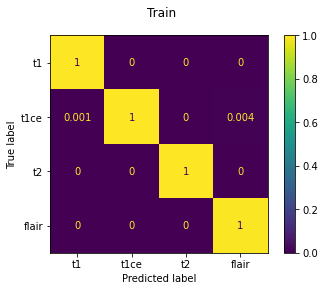

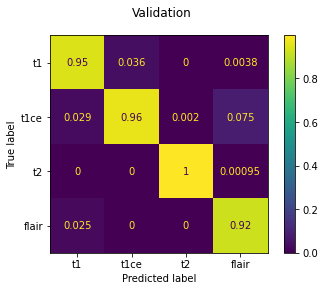

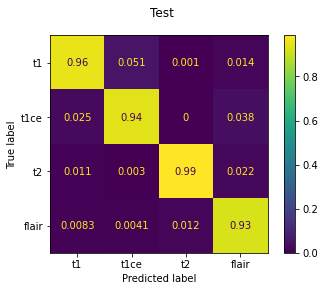

In [15]:
def test_model(model):
    train_preds,train_labels,cm_train,cm_disp_train = confusion_matrix(model,gen_train,"Train",len(gen_val))
    val_preds,val_labels,cm_val,cm_disp_val = confusion_matrix(model,gen_val,"Validation")
    test_preds,test_labels,cm_test,cm_disp_test = confusion_matrix(model,gen_test,"Test")
def load_model(path):
    m = keras.models.load_model(path)
    print(m.summary())
    return m
best_model = load_model(model_dir)
print("Best Epoch")
test_model(best_model)

Last Epoch
Accuracy - Train: 99.724%
Accuracy - Validation: 94.834%
Accuracy - Test: 94.969%


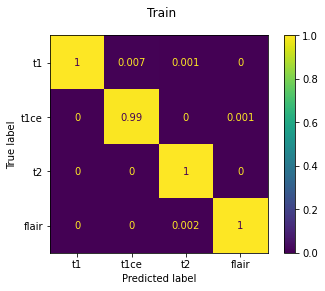

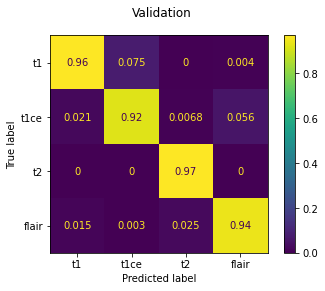

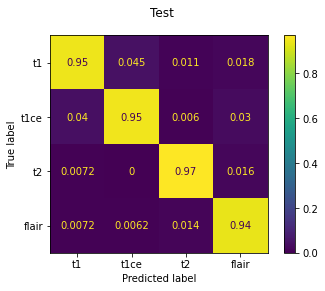

In [16]:

print("Last Epoch")
test_model(model)
